In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import os

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine('sqlite:///' + os.path.join('Resources', 'hawaii.sqlite'))

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
# id, date, prcp, station, tobs
Measurement = Base.classes.measurement

# elevation, id, latitude, longitude, name, station
State = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
session.query(func.max(Measurement.date)).first()

('2017-08-23')

In [72]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
end_date_tmp = session.query(func.max(Measurement.date)).first()[0]
end_date = dt.datetime.strptime(end_date_tmp, '%Y-%M-%d')
start_date = end_date - relativedelta(months=12)

# Perform a query to retrieve the data and precipitation scores
statement = session.query(Measurement.date, Measurement.prcp) \
    .filter(Measurement.date >= start_date) \
    .filter(Measurement.date <= end_date) \
    .filter(Measurement.prcp != None) \
    .all()

# id, prcp, station, tobs, date
# Save the query results as a Pandas DataFrame and set the index to the date column
data = [entry for entry in statement]
one_year_data_df = pd.DataFrame(data).sort_values('date')

# Sort the dataframe by date
plot_range = pd.date_range(start_date, end_date, periods=12)
# Use Pandas Plotting with Matplotlib to plot the data

#one_year_data_df.plot.bar(rot=90, figsize=(20,3))
subset = one_year_data_df.drop_duplicates(['date', 'prcp']).groupby('date').max().copy()
subset.loc[subset['prcp'] > 1.2, :].plot.bar(rot=45, figsize=(20,3))


In [ ]:
# Use Pandas to calcualte the summary statistics for the precipitation data


# Exploratory Station Analysis

In [167]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(func.count(State.station)).first()[0]
print(f"Total stations {total_stations}")

Total stations 9


In [169]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
activity = func.count(Measurement.id).label('activity')
station_activity_data = session.query(State.station, State.name, activity) \
    .filter(State.station == Measurement.station) \
    .group_by(State.station, State.name) \
    .order_by(activity.desc()) \
    .all()
pd.DataFrame(station_activity_data)

station                                    name  activity
0  USC00519281                     WAIHEE 837.5, HI US      2772
1  USC00519397                    WAIKIKI 717.2, HI US      2724
2  USC00513117                    KANEOHE 838.1, HI US      2709
3  USC00519523      WAIMANALO EXPERIMENTAL FARM, HI US      2669
4  USC00516128            MANOA LYON ARBO 785.2, HI US      2612
5  USC00514830  KUALOA RANCH HEADQUARTERS 886.9, HI US      2202
6  USC00511918       HONOLULU OBSERVATORY 702.2, HI US      1979
7  USC00517948                       PEARL CITY, HI US      1372
8  USC00518838              UPPER WAHIAWA 874.3, HI US       511

In [235]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = station_activity_data[0][0]
max_temp = func.max(Measurement.tobs).label('max')
min_temp = func.min(Measurement.tobs).label('min')
avg_temp = func.avg(Measurement.tobs).label('avg')

station, max_val, min_val, avg_val = session.query(Measurement.station, max_temp, min_temp, avg_temp) \
    .filter(Measurement.station == most_active_station) \
    .group_by(Measurement.station) \
    .first()
print(f"[{station}]: max ({max_val}), min ({min_val}), avg ({avg_val:.2f})")

[USC00519281]: max (85.0), min (54.0), avg (71.66)


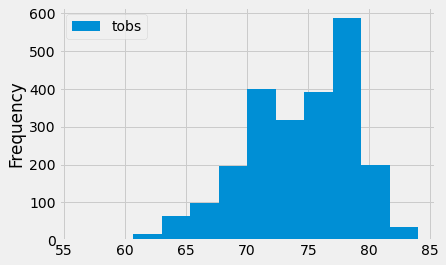

In [47]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(Measurement.date, Measurement.tobs) \
    .filter(Measurement.date >= start_date) \
    .filter(Measurement.date <= end_date) \
    .all()
pd.DataFrame(temp_data).plot.hist(bins=12)

# Close session

In [245]:
# Close Session
session.close()